# Midterm. Обучение нейронных сетей на PyTorch.


Вам необходимо заполнить пропуски в ноутбуке. Кое-где вас просят сделать выводы о проделанной работе. Постарайтесь ответить на вопросы обдуманно и развёрнуто. 


In [499]:
import torch
from torch import nn
from torch import functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Дисклеймер про CrossEntropyLoss и NLLLoss

Обычно в PyTorch не нужно делать Softmax как последний слой модели. 

* Если Вы используете NLLLoss, то ему на вход надо давать лог вероятности, то есть выход слоя LogSoftmax. (Просто результат софтмакса, к которому применен логарифм)
* Если Вы используете CrossEntropyLoss, то применение LogSoftmax уже включено внутрь лосса, поэтому ему на вход надо подавать просто выход обычного линейного слоя без активации. По сути CrossEntropyLoss = LogSoftmax + NLLLoss

Зачем такие сложности, чтобы посчитать обычную кросс энтропию, которую мы использовали как лосс еще в логистической регрессии? Дело в том, что нам в любом случае придется взять логарифм от результатов софтмакса, а если делать это одной функцией, то можно сделать более устойчивую реализацию, которая даст меньшую вычислительную погрешность. 

Таким образом, если у вас в конце сети, решающей задачу классификации, стоит просто линейный слой без активации, то вам нужно использовать CrossEntropy. В этой домашке везде используется лосс CrossEntropy

# Задание 1. Создайте генератор батчей. 

В этот раз мы хотим сделать генератор, который будет максимально похож на то, что используется в реальном обучении. 

С помощью numpy вам нужно перемешать исходную выборку и выбирать из нее батчи размером batch_size, если размер выборки не делился на размер батча, то последний батч должен иметь размер меньше batch_size и состоять просто из всех оставшихся объектов. Возвращать нужно в формате (X_batch, y_batch). Необходимо написать именно генератор, то есть вместо return использовать yield. 

Хорошая статья про генераторы: https://habr.com/ru/post/132554/


**Ответ на задание - код**


In [500]:
def batch_generator(X, y, batch_size):
    np.random.seed(42)
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    # YOUR CODE
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], y[batch_idx]

Попробуем потестировать наш код

In [501]:
from inspect import isgeneratorfunction
assert isgeneratorfunction(batch_generator), "batch_generator должен быть генератором! В условии есть ссылка на доки"

X = np.array([
              [1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]
])
y = np.array([
              1, 2, 3
])

# Проверим shape первого батча
iterator = batch_generator(X, y, 2)
X_batch, y_batch = next(iterator)
assert X_batch.shape == (2, 3), y_batch.shape == (2,)
assert np.allclose(X_batch, X[:2]), np.allclose(y_batch, y[:2])

# Проверим shape последнего батча (их всего два)
X_batch, y_batch = next(iterator)
assert X_batch.shape == (1, 3), y_batch.shape == (1,)
assert np.allclose(X_batch, X[2:]), np.allclose(y_batch, y[2:])

# Проверим, что итерации закончились
iter_ended = False
try:
    next(iterator)
except StopIteration:
    iter_ended = True
assert iter_ended

# Еще раз проверим то, сколько батчей создает итератор
X = np.random.randint(0, 100, size=(1000, 100))
y = np.random.randint(-1, 1, size=(1000, 1))
num_iter = 0
for _ in batch_generator(X, y, 3):
    num_iter += 1
assert num_iter == (1000 // 3 + 1)

# Задание 2. Обучите модель для классификации звезд

Загрузите датасет из файла sky_data.csv, разделите его на train/test и обучите на нем нейронную сеть (архитектура ниже). Обучайте на батчах с помощью оптимизатора Adam, lr подберите сами, пробуйте что-то вроде 1e-2

Архитектура:

1. Dense Layer с relu активацией и 50 нейронами
2. Dropout 80% (если другой keep rate дает сходимость лучше, то можно изменить) (попробуйте 50%) 
3. BatchNorm
4. Dense Layer с relu активацией и 100 нейронами
5. Dropout 80% (если другой keep rate дает сходимость лучше, то можно изменить) (попробуйте для разнообразия 50%)
6. BatchNorm
7. Выходной Dense слой c количеством нейронов, равному количеству классов

Лосс - CrossEntropy.

В датасете классы представлены строками, поэтому классы нужно закодировать. Для этого в строчке ниже объявлен dict, с помощью него и функции map превратите столбец с таргетом в целое число. Кроме того, за вас мы выделили признаки, которые нужно использовать.

### Загрузка и обработка данных

In [502]:
feature_columns = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'camcol', 'field']
target_column = 'class'

target_mapping = {
    'GALAXY': 0,
    'STAR': 1,
    'QSO': 2
}

In [503]:
data = pd.read_csv('https://drive.google.com/uc?id=1K-8CtATw6Sv7k2dXco1fL5MAhTbKtIH3')
data['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

In [504]:
data.head(10)

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512
5,1.237650e+18,183.847174,0.173694,19.43133,18.46779,18.16451,18.01475,18.04155,752,301,4,269,3.649550e+17,STAR,0.000315,324,51666,594
6,1.237650e+18,183.864379,0.019201,19.38322,17.88995,17.10537,16.66393,16.36955,752,301,4,269,3.232870e+17,GALAXY,0.100242,287,52023,559
7,1.237650e+18,183.900081,0.187473,18.97993,17.84496,17.38022,17.20673,17.07071,752,301,4,269,3.722370e+18,STAR,0.000315,3306,54922,515
8,1.237650e+18,183.924588,0.097246,17.90616,16.97172,16.67541,16.53776,16.47596,752,301,4,270,3.638290e+17,STAR,0.000089,323,51615,595
9,1.237650e+18,183.973498,0.081626,18.67249,17.71375,17.49362,17.28284,17.22644,752,301,4,270,3.243690e+17,GALAXY,0.040508,288,52000,400


In [505]:
# Extract Features
X = data[feature_columns]
# Extract target
# encode target with target_mapping
y = data[target_column].map(target_mapping)

print(X)
print(y)

              ra        dec         u         g         r         i         z  \
0     183.531326   0.089693  19.47406  17.04240  15.94699  15.50342  15.22531   
1     183.598371   0.135285  18.66280  17.21449  16.67637  16.48922  16.39150   
2     183.680207   0.126185  19.38298  18.19169  17.47428  17.08732  16.80125   
3     183.870529   0.049911  17.76536  16.60272  16.16116  15.98233  15.90438   
4     183.883288   0.102557  17.55025  16.26342  16.43869  16.55492  16.61326   
...          ...        ...       ...       ...       ...       ...       ...   
9995  131.316413  51.539547  18.81777  17.47053  16.91508  16.68305  16.50570   
9996  131.306083  51.671341  18.27255  17.43849  17.07692  16.71661  16.69897   
9997  131.552562  51.666986  18.75818  17.77784  17.51872  17.43302  17.42048   
9998  131.477151  51.753068  18.88287  17.91068  17.53152  17.36284  17.13988   
9999  131.665012  51.805307  19.27586  17.37829  16.30542  15.83548  15.50588   

       run  camcol  field  

Нормализация фичей

In [506]:
# Просто вычтите среднее и поделитe на стандартное отклонение (с помощью пандас). Также преобразуйте всё в np.array
X = (X - X.mean()) / X.std()

# min-max normalization
# X = (X - X.min()) / (X.max() - X.min())

In [507]:
print(X.max())

ra         1.786276
dec        2.130163
u          1.183295
g          2.693976
r          7.455837
i         10.155896
z          5.327702
run        1.576865
camcol     1.411189
field      2.863983
dtype: float64


In [508]:
X = X.to_numpy()
y = y.to_numpy()

In [509]:
print(X[0])
print(y[0])

[ 0.16745005 -0.58489347  1.0314348  -0.34854195 -0.8372384  -0.94601041
 -0.99529177 -0.83801899  0.21084118 -0.21761955]
1


In [510]:
assert type(X) == np.ndarray and type(y) == np.ndarray, 'Проверьте, что получившиеся массивы являются np.ndarray'
assert np.allclose(y[:5], [1,1,0,1,1])
assert X.shape == (10000, 10)
assert np.allclose(X.mean(axis=0), np.zeros(10)) and np.allclose(X.std(axis=0), np.ones(10)), 'Данные не отнормированы'


AssertionError: Данные не отнормированы

Обучение

In [511]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# Превратим данные в тензоры, чтобы потом было удобнее
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

Хорошо, данные мы подготовили, теперь надо объявить модель

Обучайте на батчах с помощью оптимизатора Adam, lr подберите сами, пробуйте что-то вроде 1e-2

Архитектура:

1. Dense Layer с relu активацией и 50 нейронами
2. Dropout 80% (если другой keep rate дает сходимость лучше, то можно изменить) (попробуйте 50%) 
3. BatchNorm
4. Dense Layer с relu активацией и 100 нейронами
5. Dropout 80% (если другой keep rate дает сходимость лучше, то можно изменить) (попробуйте для разнообразия 50%)
6. BatchNorm
7. Выходной Dense слой c количеством нейронов, равному количеству классов

Лосс - CrossEntropy.

In [512]:
torch.manual_seed(42) 
np.random.seed(42)
eta = 0.01

model = nn.Sequential(
    nn.Linear(10, 50),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.Linear(50, 100),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=100),
    nn.Dropout(p=0.5),
    nn.Linear(100, 3),
    nn.BatchNorm1d(num_features=3),
    nn.ReLU()
)

    
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

print(model)

Sequential(
  (0): Linear(in_features=10, out_features=50, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.25, inplace=False)
  (3): Linear(in_features=50, out_features=100, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=100, out_features=3, bias=True)
  (8): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
)


### Обучающий цикл

In [514]:
def train(X_train, y_train, X_test, y_test, num_epoch):
    train_losses = []
    test_losses = []
    for i in range(num_epoch):
        epoch_train_losses = []
        epoch_test_losses = []
        #optimizer.zero_grad()
        #avg_loss = 0.
        for X_batch, y_batch in batch_generator(X_train, y_train, 500):
            # На лекции мы рассказывали, что дропаут работает по-разному во время обучения и реального предсказания
            # Чтобы это учесть нам нужно включать и выключать режим обучения, делается это командой ниже
            model.train(True)
            
            # Посчитаем предсказание и лосс
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            
            # зануляем градиент
            optimizer.zero_grad()
            
            # backward
            # ОБНОВЛЯЕМ веса
            loss.backward()
            optimizer.step()
            
            # Запишем число (не тензор) в наши батчевые лоссы
            epoch_train_losses.append(loss.item()) 
            
            #loss = loss / len(y_batch)
            #avg_loss += loss.item() / len(X_train)
            
            
        
        # Теперь посчитаем лосс на тесте
        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in batch_generator(X_test, y_test, 500):
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                epoch_test_losses.append(loss.item())
        
        
        train_loss = np.mean(epoch_train_losses)
        train_losses.append(train_loss)
        test_loss = np.mean(epoch_test_losses)
        test_losses.append(test_loss)
        print('Epoch {}/{} \t train_loss={:.4f} \t test_loss={:.4f}'.format(
        i + 1, num_epoch, train_loss, test_loss))
    return train_losses, test_losses

In [515]:
def check_loss_decreased():
    print("На графике сверху, точно есть сходимость? Точно-точно? [Y/N]")
    s = input()
    if s.lower() == 'y':
        print("Хорошо!")
    else:
        raise RuntimeError("Можно уменьшить дропаут, уменьшить lr, поправить архитектуру, etc")

Epoch 1/100 	 train_loss=0.8999 	 test_loss=0.8108
Epoch 2/100 	 train_loss=0.7328 	 test_loss=0.6704
Epoch 3/100 	 train_loss=0.6348 	 test_loss=0.5510
Epoch 4/100 	 train_loss=0.5129 	 test_loss=0.4156
Epoch 5/100 	 train_loss=0.4119 	 test_loss=0.3399
Epoch 6/100 	 train_loss=0.3501 	 test_loss=0.3059
Epoch 7/100 	 train_loss=0.3140 	 test_loss=0.2834
Epoch 8/100 	 train_loss=0.2893 	 test_loss=0.2589
Epoch 9/100 	 train_loss=0.2715 	 test_loss=0.2442
Epoch 10/100 	 train_loss=0.2568 	 test_loss=0.2344
Epoch 11/100 	 train_loss=0.2477 	 test_loss=0.2345
Epoch 12/100 	 train_loss=0.2383 	 test_loss=0.2132
Epoch 13/100 	 train_loss=0.2261 	 test_loss=0.2066
Epoch 14/100 	 train_loss=0.2266 	 test_loss=0.2182
Epoch 15/100 	 train_loss=0.2321 	 test_loss=0.2115
Epoch 16/100 	 train_loss=0.2199 	 test_loss=0.1969
Epoch 17/100 	 train_loss=0.2104 	 test_loss=0.1899
Epoch 18/100 	 train_loss=0.2099 	 test_loss=0.1904
Epoch 19/100 	 train_loss=0.2020 	 test_loss=0.1934
Epoch 20/100 	 train_

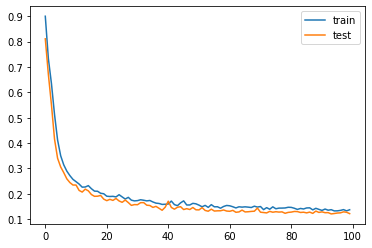

На графике сверху, точно есть сходимость? Точно-точно? [Y/N]
y
Хорошо!


In [516]:
#Подберите количество эпох так, чтобы график loss сходился
train_losses, test_losses = train(X_train, y_train, X_test, y_test, 100) 
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()
    
check_loss_decreased()
assert train_losses[-1] < 0.3 and test_losses[-1] < 0.3

### Вычислите accuracy получившейся модели на train и test

In [517]:
from sklearn.metrics import accuracy_score


model.eval()
train_pred_labels = torch.max(model(X_train), 1).indices
test_pred_labels = torch.max(model(X_test), 1).indices

#print(train_pred_labels)
#print(test_pred_labels)

train_acc = accuracy_score(y_train, train_pred_labels)
test_acc = accuracy_score(y_test, test_pred_labels)

assert train_acc > 0.9, "Если уж классифицировать звезды, которые уже видел, то не хуже, чем в 90% случаев"
assert test_acc > 0.9, "Новые звезды тоже надо классифицировать хотя бы в 90% случаев"

print("Train accuracy: {}\nTest accuracy: {}".format(train_acc, test_acc))


Train accuracy: 0.9690666666666666
Test accuracy: 0.9636


# Задание 3. Исправление ошибок в архитектуре

Только что вы обучили полносвязную нейронную сеть. Теперь вам предстоит проанализировать архитектуру нейронной сети ниже, исправить в ней ошибки и  обучить её с помощью той же функции train. 

Будьте осторожнее и убедитесь, что перед запуском train вы вновь переопределили все необходимые внешние переменные (train обращается к глобальным переменным, в целом так делать не стоит, но сейчас это было оправдано, так как иначе нам пришлось бы передавать порядка 7-8 аргументов).

Чтобы у вас получилась такая же архитектура, как у нас, и ответы совпали, давайте определим некоторые правила, как исправлять ошибки:

1. Если вы видите лишний нелинейный слой, который стоит не на своем месте, просто удалите его. (не нужно добавлять новые слои, чтобы сделать постановку изначального слоя разумной. Удалять надо самый последний слой, который все портит. Для линейных слоев надо что-то исправить, а не удалить его)
2. Если у слоя нет активации, то добавьте ReLU или другую подходящую активацию
3. Если что-то не так с learning_rate, то поставьте 1e-2
4. Если что-то не так с параметрами, считайте первый параметр, который появляется, как верный (т.е. далее в сети должен использоваться он).
5. Ошибки могут быть и в полносвязных слоях. 
6. Любые другие проблемы решаются более менее однозначно, если же у вас есть серьезные сомнения, то напишите в беседу в телеграме и пинганите меня @runfme


Задача все та же - классификация небесных объектов на том же датасете. После исправления сети вам нужно обучить ее.

**Ответ на задачу - средний лосс на тестовом датасете**

In [0]:
torch.manual_seed(42)   
np.random.seed(42)
# WRONG ARCH
model = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(6, 50),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(100, 200),
    nn.Softmax(),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(200, 3),
    nn.Dropout(p=0.5)
)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters[:-2], lr=1e-100)

In [549]:
# RIGHT ARCH
torch.manual_seed(42)   
np.random.seed(42)
model = nn.Sequential(
    nn.Linear(10, 50),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.Linear(50, 100),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.Linear(100, 200),
    nn.ReLU(),
    nn.Dropout(p=0.25),
    nn.Linear(200, 3),
    nn.ReLU()
)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
print(model)

Sequential(
  (0): Linear(in_features=10, out_features=50, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.25, inplace=False)
  (3): Linear(in_features=50, out_features=100, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.25, inplace=False)
  (6): Linear(in_features=100, out_features=200, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.25, inplace=False)
  (9): Linear(in_features=200, out_features=3, bias=True)
  (10): ReLU()
)


### Обучите и протестируйте модель так же, как вы это сделали в задаче 2. Вычислите accuracy.

In [550]:
def train2(X_train, y_train, X_test, y_test, num_epoch):
    train_losses = []
    test_losses = []
    for i in range(num_epoch):
        epoch_train_losses = []
        epoch_test_losses = []
        #optimizer.zero_grad()
        #avg_loss = 0.
        for X_batch, y_batch in batch_generator(X_train, y_train, 500):
            model.train(True)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            
            epoch_train_losses.append(loss.item())
        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in batch_generator(X_test, y_test, 500):
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                epoch_test_losses.append(loss.item())
        
        
        train_loss = np.mean(epoch_train_losses)
        train_losses.append(train_loss)
        test_loss = np.mean(epoch_test_losses)
        test_losses.append(test_loss)
        print('Epoch {}/{} \t train_loss={:.4f} \t test_loss={:.4f}'.format(
        i + 1, num_epoch, train_loss, test_loss))
    return train_losses, test_losses

Epoch 1/100 	 train_loss=0.8012 	 test_loss=0.6761
Epoch 2/100 	 train_loss=0.6383 	 test_loss=0.6058
Epoch 3/100 	 train_loss=0.5762 	 test_loss=0.5246
Epoch 4/100 	 train_loss=0.4945 	 test_loss=0.3698
Epoch 5/100 	 train_loss=0.3813 	 test_loss=0.2823
Epoch 6/100 	 train_loss=0.3154 	 test_loss=0.2600
Epoch 7/100 	 train_loss=0.2781 	 test_loss=0.2434
Epoch 8/100 	 train_loss=0.2591 	 test_loss=0.2268
Epoch 9/100 	 train_loss=0.2443 	 test_loss=0.2152
Epoch 10/100 	 train_loss=0.2346 	 test_loss=0.2118
Epoch 11/100 	 train_loss=0.2256 	 test_loss=0.2102
Epoch 12/100 	 train_loss=0.2214 	 test_loss=0.1942
Epoch 13/100 	 train_loss=0.2148 	 test_loss=0.1878
Epoch 14/100 	 train_loss=0.2137 	 test_loss=0.1973
Epoch 15/100 	 train_loss=0.2075 	 test_loss=0.1926
Epoch 16/100 	 train_loss=0.2085 	 test_loss=0.1922
Epoch 17/100 	 train_loss=0.2035 	 test_loss=0.1941
Epoch 18/100 	 train_loss=0.2028 	 test_loss=0.1917
Epoch 19/100 	 train_loss=0.2026 	 test_loss=0.1960
Epoch 20/100 	 train_

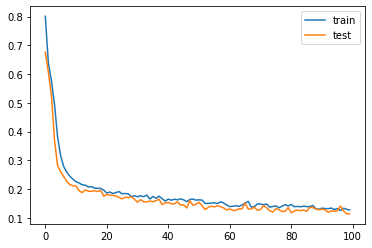

In [551]:
train_losses, test_losses = train2(X_train, y_train, X_test, y_test, 100) 
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()

In [552]:
from sklearn.metrics import accuracy_score


model.eval()
train_pred_labels = torch.max(model(X_train), 1).indices
test_pred_labels = torch.max(model(X_test), 1).indices

train_acc = accuracy_score(y_train, train_pred_labels)
test_acc = accuracy_score(y_test, test_pred_labels)

#assert train_acc > 0.9, "Если уж классифицировать звезды, которые уже видел, то не хуже, чем в 90% случаев"
#assert test_acc > 0.9, "Новые звезды тоже надо классифицировать хотя бы в 90% случаев"

print("Train accuracy: {}\nTest accuracy: {}".format(train_acc, test_acc))


Train accuracy: 0.9726666666666667
Test accuracy: 0.9644


# Задание 4. Stack layers

Давайте посмотрим, когда добавление перестает улучшать метрики. Увеличивайте блоков из слоев в сети, пока минимальный лосс на тестовом датасете за все время обучения не перестанет уменьшаться (20 эпох). 

Стоит помнить, что нельзя переиспользовать слои с предыдущих обучений, потому что они уже будут с подобранными весами.

**Чтобы получить воспроизводимость и идентичный нашему ответ, надо объявлять все слои в порядке, в котором они применяются внутри модели. Это важно, если вы будете собирать свою модель из частей. Перед объявлением этих слоев по порядку напишите**
> torch.manual_seed(42)   
> np.random.seed(42)

**При чем каждый раз, когда вы заново создаете модель, перезадавайте random seeds**

**Опитимизатор - Adam(lr=1e-2)**


In [0]:
# МОДЕЛЬ ДЛЯ ПРИМЕРА, НА САМОМ ДЕЛЕ ВАМ ПРИДЕТСЯ СОЗДАВАТЬ НОВУЮ МОДЕЛЬ ДЛЯ КАЖДОГО КОЛИЧЕСТВА БЛОКОВ
model = nn.Sequential(
    nn.Linear(len(feature_columns), 100),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    # Начало блока, который надо вставалять много раз
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    # Конец блока
    nn.Linear(100, 3)
    # Блока Softmax нет, поэтому нам нужно использовать лосс - CrossEntropyLoss
)

In [0]:
# Вы уже многое умеете, поэтому теперь код надо написать самому
# Идея - разделить модель на части.
# Вначале создать head часть как Sequential модель, потом в цикле создать Sequential модели, которые представляют
# из себя блоки, потом создать tail часть тоже как Sequential, а потом объединить их в одну Sequential модель 
# вот таким кодом: nn.Sequential(header, *blocks, footer)
# Важная идея тут состоит в том, что модели могут быть частями других моделей)
<YOUR CODE>

## Задание 5. Сделайте выводы 
Начиная с какого количества блоков минимальный лосс за время обучения увеличивается? Почему лишнее количество блоков не помогает модели? 